In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from numpy import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import layers,datasets
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from tensorflow import keras
import gc
# import warnings
# warnings.filterwarnings('ignore')
import lightgbm as lgb
import category_encoders as ce
from sklearn.metrics import f1_score,classification_report,roc_auc_score
from impala.dbapi import connect
from impala.util import as_pandas
import pymysql

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
pd.set_option('display.max_rows',None)

In [4]:
# 获取近期所有计划('2021年2月1号开始')
def get_plan_info():
    conn = pymysql.connect(host='192.168.0.65', port=3306, user='readonly',
                        passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t', db='db_ptom')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
                * 
            FROM
                db_ptom.ptom_third_plan p
            WHERE
                game_id IN (
            1000840,
            1000862,
            1000869,
            1000935,
            1000947,
            1000960,
            1001049,
            1001058,
            1001063,
            1001079,
            1001059,
            1000954,
            1000993,
            1000994,
            1000992,
            1001258,
            1001294,
            1001295,
            1001310,
            1001155,
            1001257,
            1001379,
            1001193,
            1001400,
            1001401,
            1001402,
            1001439,
            1001413,
            1001414,
            1001420,
            1001425,
            1001426,
            1001430,
            1001431,
            1001259,
            1000985,
            1001454,
            1001455,
            1001457,
            1001460,
            1001194,
            1001484,
            1001440,
            1001540,
            1001541
                ) 
                AND media_id = 10
                AND create_time>='2021-02-01'
                AND create_time<= date(NOW() - interval 24 hour)
                            AND plan_id >= (
                                select plan_id from db_ptom.ptom_plan
                                where create_time >= '2021-02-01'
                                and create_time <= '2021-02-02'
                                limit 1
                            )
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [5]:
# 获取image_id,label_ids
def get_image_info():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                        passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id,
            a.image_id,
            b.label_ids
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN
            db_data_ptom.ptom_image_info b
        on a.image_id = b.image_id
        WHERE
            a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
            AND a.media_id = 10 
            AND a.create_time >= '2021-02-01' 
        GROUP BY
            a.chl_user_id,
            a.source_id,
            a.image_id
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [6]:
# 获取计划运营指标
def get_launch_report():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                        passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            tdate,
            channel_id,
            source_id,
            amount,
            create_role_num,
            pay_role_user_num,
            new_role_money 
        FROM
            db_stdata.st_lauch_report a 
        WHERE
            a.tdate_type = 'day' 
            AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
            AND a.tdate >= '2021-02-01'
            AND a.media_id = 10
            ANd a.amount>0
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [7]:
# 获取近期账号维度窗口期统计数据
def getAdData(conn, begin, end, n):
    originSql = '''
              SELECT
                a.ad_account_id AS 'ad_account_id',
                ifnull( a.ad_amount, 0 ) AS 'ad_amount',
                ifnull( a.ad_create_role_num, 0 ) AS 'ad_create_role_num',
                ifnull( a.ad_new_role_money, 0 ) AS 'ad_new_role_money',
                ifnull( a.ad_pay_role_user_num, 0 ) AS 'ad_pay_role_user_num',
                ifnull( a.ad_source_num, 0 ) AS 'ad_source_num',
                IFNULL( b.ad_valid_source_num, 0 ) AS 'ad_valid_source_num',
                (
                CASE
                        
                        WHEN ifnull( a.ad_create_role_num, 0 )= 0 THEN
                        0 ELSE IFNULL( a.ad_pay_role_user_num, 0 ) / ifnull( a.ad_create_role_num, 0 ) 
                    END 
                    ) AS 'ad_pay_rate',
                    (
                    CASE
                            
                            WHEN ifnull( a.ad_create_role_num, 0 )= 0 THEN
                            0 ELSE IFNULL( a.ad_amount, 0 ) / ifnull( a.ad_create_role_num, 0 ) 
                        END 
                        ) AS 'ad_create_role_cost',
                        (
                        CASE
                                
                                WHEN ifnull( a.ad_pay_role_user_num, 0 )= 0 THEN
                                0 ELSE IFNULL( a.ad_amount, 0 ) / ifnull( a.ad_pay_role_user_num, 0 ) 
                            END 
                            ) AS 'ad_create_role_pay_cost',
                            (
                            CASE
                                    
                                    WHEN ifnull( a.ad_source_num, 0 )= 0 THEN
                                    0 ELSE IFNULL( b.ad_valid_source_num, 0 ) / ifnull( a.ad_source_num, 0 ) 
                                END 
                                ) AS 'ad_valid_source_rate',
                                (
                                CASE
                                        
                                        WHEN ifnull( a.ad_amount, 0 )= 0 THEN
                                        0 ELSE IFNULL( a.ad_new_role_money, 0 ) / ifnull( a.ad_amount, 0 ) 
                                    END 
                                    ) AS 'ad_create_role_roi' 
                                FROM
                                    (
                                    SELECT
                                        a.ad_account_id,
                                        ifnull( sum( a.amount ), 0 ) AS 'ad_amount',
                                        ifnull( sum( a.create_role_num ), 0 ) AS 'ad_create_role_num',
                                        ifnull( sum( b.new_role_money ), 0 ) AS 'ad_new_role_money',
                                        ifnull( sum( b.pay_role_user_num ), 0 ) AS 'ad_pay_role_user_num',
                                        count( DISTINCT a.source_id ) AS 'ad_source_num' 
                                    FROM
                                        (
                                        SELECT
                                            b.ad_account_id,
                                            b.doc_id,
                                            a.game_id,
                                            a.channel_id,
                                            a.source_id,
                                            a.amount,
                                            a.create_role_num 
                                        FROM
                                            db_stdata.st_lauch_report a
                                            INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                            AND a.source_id = b.source_id 
                                            AND a.channel_id = b.chl_user_id 
                                        WHERE
                                            a.tdate_type = 'day' 
                                            AND a.tdate >= '{begin}' 
                                            AND a.tdate <= '{end}' AND a.amount > 100 
                                            AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL )) a
                                        LEFT JOIN (
                                        SELECT
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id,
                                            b.ad_account_id,
                                            sum( c.create_role_money ) new_role_money,
                                            IFNULL( sum( c.pay_role_user_num ), 0 ) AS pay_role_user_num 
                                        FROM
                                            db_stdata.st_game_days c
                                            INNER JOIN db_data_ptom.ptom_plan b ON c.game_id = b.game_id 
                                            AND c.source_id = b.source_id 
                                            AND c.channel_id = b.chl_user_id 
                                        WHERE
                                            c.report_days = {n} 
                                            AND c.tdate = '{end}' 
                                            AND c.tdate_type = 'day' 
                                            AND c.query_type = 13 
                                            AND c.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
                                        GROUP BY
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id 
                                        HAVING
                                            ( new_role_money > 0 OR pay_role_user_num > 0 ) 
                                        ) b ON a.source_id = b.source_id 
                                        AND a.channel_id = b.channel_id 
                                    GROUP BY
                                        a.ad_account_id 
                                    ) a
                                    LEFT JOIN (
                                    SELECT
                                        b.ad_account_id,
                                        count( DISTINCT b.plan_id ) AS 'ad_valid_source_num' 
                                    FROM
                                        db_stdata.st_lauch_report a
                                        INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                        AND a.source_id = b.source_id 
                                        AND a.channel_id = b.chl_user_id 
                                    WHERE
                                        a.tdate_type = 'day' 
                                        AND a.tdate >= '{begin}' 
                                        AND a.tdate <= '{end}' AND a.amount > 100  
                                        AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
                                        AND a.pay_role_user_num > 0 
                                    GROUP BY
                                    b.ad_account_id 
                ) b ON A.ad_account_id = B.ad_account_id
    '''
    finalSql = originSql.format(begin=begin, end=end, n=n)
    result = pd.read_sql(finalSql, conn)
    return result

In [8]:
# 获取素材报表数据
def getImData(conn, begin, end, n):
    originSql = '''
            SELECT
                a.image_id AS 'image_id',
                ifnull( a.im_amount, 0 ) AS 'im_amount',
                ifnull( a.im_create_role_num, 0 ) AS 'im_create_role_num',
                ifnull( a.im_new_role_money, 0 ) AS 'im_new_role_money',
                ifnull( a.im_pay_role_user_num, 0 ) AS 'im_pay_role_user_num',
                ifnull( a.im_source_num, 0 ) AS 'im_source_num',
                IFNULL( b.im_valid_source_num, 0 ) AS 'im_valid_source_num',
                (
                CASE
                        
                        WHEN ifnull( a.im_create_role_num, 0 )= 0 THEN
                        0 ELSE IFNULL( a.im_pay_role_user_num, 0 ) / ifnull( a.im_create_role_num, 0 ) 
                    END 
                    ) AS 'im_pay_rate',
                    (
                    CASE
                            
                            WHEN ifnull( a.im_create_role_num, 0 )= 0 THEN
                            0 ELSE IFNULL( a.im_amount, 0 ) / ifnull( a.im_create_role_num, 0 ) 
                        END 
                        ) AS 'im_create_role_cost',
                        (
                        CASE
                                
                                WHEN ifnull( a.im_pay_role_user_num, 0 )= 0 THEN
                                0 ELSE IFNULL( a.im_amount, 0 ) / ifnull( a.im_pay_role_user_num, 0 ) 
                            END 
                            ) AS 'im_create_role_pay_cost',
                            (
                            CASE
                                    
                                    WHEN ifnull( a.im_source_num, 0 )= 0 THEN
                                    0 ELSE IFNULL( b.im_valid_source_num, 0 ) / ifnull( a.im_source_num, 0 ) 
                                END 
                                ) AS 'im_valid_source_rate',
                                (
                                CASE
                                        
                                        WHEN ifnull( a.im_amount, 0 )= 0 THEN
                                        0 ELSE IFNULL( a.im_new_role_money, 0 ) / ifnull( a.im_amount, 0 ) 
                                    END 
                                    ) AS 'image_create_role_roi' 
                                FROM
                                    (
                                    SELECT
                                        a.image_id,
                                        ifnull( sum( a.amount ), 0 ) AS 'im_amount',
                                        ifnull( sum( a.create_role_num ), 0 ) AS 'im_create_role_num',
                                        ifnull( sum( b.new_role_money ), 0 ) AS 'im_new_role_money',
                                        ifnull( sum( b.pay_role_user_num ), 0 ) AS 'im_pay_role_user_num',
                                        count( DISTINCT a.source_id ) AS 'im_source_num' 
                                    FROM
                                        (
                                        SELECT
                                            b.image_id,
                                            a.game_id,
                                            a.channel_id,
                                            a.source_id,
                                            a.amount,
                                            a.create_role_num 
                                        FROM
                                            db_stdata.st_lauch_report a
                                            INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                            AND a.source_id = b.source_id 
                                            AND a.channel_id = b.chl_user_id                                        
                                        WHERE
                                            a.tdate_type = 'day' 
                                            AND a.tdate >= '{begin}' 
                                            AND a.tdate <= '{end}' AND a.amount > 100 
                                            AND b.image_id IS NOT NULL 
                                            AND b.image_id <> '' 
                                            AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL )) a
                                        LEFT JOIN (
                                        SELECT
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id,
                                            b.image_id,
                                            sum( c.create_role_money ) new_role_money,
                                            IFNULL( sum( c.pay_role_user_num ), 0 ) AS pay_role_user_num 
                                        FROM
                                            db_stdata.st_game_days c
                                            INNER JOIN db_data_ptom.ptom_plan b ON c.game_id = b.game_id 
                                            AND c.source_id = b.source_id 
                                            AND c.channel_id = b.chl_user_id 
                                        WHERE
                                            c.report_days = {n} 
                                            AND c.tdate = '{end}' 
                                            AND c.tdate_type = 'day' 
                                            AND c.query_type = 13 
                                            AND b.image_id IS NOT NULL 
                                            AND b.image_id <> '' 
                                            AND c.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
                                        GROUP BY
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id 
                                        HAVING
                                            ( new_role_money > 0 OR pay_role_user_num > 0 ) 
                                        ) b ON a.source_id = b.source_id 
                                        AND a.channel_id = b.channel_id 
                                    GROUP BY
                                        a.image_id 
                                    ) a
                                    LEFT JOIN (
                                    SELECT
                                        b.image_id,
                                        count( DISTINCT b.plan_id ) AS 'im_valid_source_num' 
                                    FROM
                                        db_stdata.st_lauch_report a
                                        INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                        AND a.source_id = b.source_id 
                                        AND a.channel_id = b.chl_user_id 
                                    WHERE
                                        a.tdate_type = 'day' 
                                        AND a.tdate >= '{begin}' 
                                        AND a.tdate <= '{end}' AND a.amount > 100 
                                        AND b.image_id IS NOT NULL 
                                        AND b.image_id <> '' 
                                        AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
                                        AND a.pay_role_user_num > 0 
                                    GROUP BY
                                        b.image_id 
                                    ) b ON A.image_id = B.image_id
    '''
    finalSql = originSql.format(begin=begin, end=end, n=n)
    result = pd.read_sql(finalSql, conn)
    return result

In [855]:
# # 获取账号+素材报表数据
# def getAdImData(conn, begin, end, n):
#     originSql = '''
#                   SELECT
#                     a.ad_account_id AS 'ad_account_id',
#                     a.image_id as 'image_id',
#                     ifnull( a.ad_amount, 0 ) AS 'ad_im_amount',
#                     ifnull( a.ad_create_role_num, 0 ) AS 'ad_im_create_role_num',
#                     ifnull( a.ad_new_role_money, 0 ) AS 'ad_im_new_role_money',
#                     ifnull( a.ad_pay_role_user_num, 0 ) AS 'ad_im_pay_role_user_num',
#                     ifnull( a.ad_source_num, 0 ) AS 'ad_im_source_num',
#                     IFNULL( b.ad_im_valid_source_num, 0 ) AS 'ad_im_valid_source_num',
#                     (
#                     CASE
                            
#                             WHEN ifnull( a.ad_create_role_num, 0 )= 0 THEN
#                             0 ELSE IFNULL( a.ad_pay_role_user_num, 0 ) / ifnull( a.ad_create_role_num, 0 ) 
#                         END 
#                         ) AS 'ad_im_pay_rate',
#                         (
#                         CASE
                                
#                                 WHEN ifnull( a.ad_create_role_num, 0 )= 0 THEN
#                                 0 ELSE IFNULL( a.ad_amount, 0 ) / ifnull( a.ad_create_role_num, 0 ) 
#                             END 
#                             ) AS 'ad_im_create_role_cost',
#                             (
#                             CASE
                                    
#                                     WHEN ifnull( a.ad_pay_role_user_num, 0 )= 0 THEN
#                                     0 ELSE IFNULL( a.ad_amount, 0 ) / ifnull( a.ad_pay_role_user_num, 0 ) 
#                                 END 
#                                 ) AS 'ad_im_create_role_pay_cost',
#                                 (
#                                 CASE
                                        
#                                         WHEN ifnull( a.ad_source_num, 0 )= 0 THEN
#                                         0 ELSE IFNULL( b.ad_im_valid_source_num, 0 ) / ifnull( a.ad_source_num, 0 ) 
#                                     END 
#                                     ) AS 'ad_im_valid_source_rate',
#                                     (
#                                     CASE
                                            
#                                             WHEN ifnull( a.ad_amount, 0 )= 0 THEN
#                                             0 ELSE IFNULL( a.ad_new_role_money, 0 ) / ifnull( a.ad_amount, 0 ) 
#                                         END 
#                                         ) AS 'ad_im_create_role_roi' 
#                                     FROM
#                                         (
#                                         SELECT
#                                             a.ad_account_id,
#                                             a.image_id,
#                                             ifnull( sum( a.amount ), 0 ) AS 'ad_amount',
#                                             ifnull( sum( a.create_role_num ), 0 ) AS 'ad_create_role_num',
#                                             ifnull( sum( b.new_role_money ), 0 ) AS 'ad_new_role_money',
#                                             ifnull( sum( b.pay_role_user_num ), 0 ) AS 'ad_pay_role_user_num',
#                                             count( DISTINCT a.source_id ) AS 'ad_source_num' 
#                                         FROM
#                                             (
#                                             SELECT
#                                                 b.ad_account_id,
#                                                 b.image_id,
#                                                 a.game_id,
#                                                 a.channel_id,
#                                                 a.source_id,
#                                                 a.amount,
#                                                 a.create_role_num 
#                                             FROM
#                                                 db_stdata.st_lauch_report a
#                                                 INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
#                                                 AND a.source_id = b.source_id 
#                                                 AND a.channel_id = b.chl_user_id 
#                                             WHERE
#                                                 a.tdate_type = 'day' 
#                                                 AND a.tdate >= '{begin}'
#                                                 AND a.tdate <= '{end}' AND a.amount > 100
#                                                 AND b.image_id IS NOT NULL 
#                                                 AND b.image_id <> '' 
#                                                 AND a.media_id = 10 
#                                             AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL )) a
#                                             LEFT JOIN (
#                                             SELECT
#                                                 c.game_id,
#                                                 c.channel_id,
#                                                 c.source_id,
#                                                 b.ad_account_id,
#                                                 b.image_id,
#                                                 sum( c.create_role_money ) new_role_money,
#                                                 IFNULL( sum( c.pay_role_user_num ), 0 ) AS pay_role_user_num 
#                                             FROM
#                                                 db_stdata.st_game_days c
#                                                 INNER JOIN db_data_ptom.ptom_plan b ON c.game_id = b.game_id 
#                                                 AND c.source_id = b.source_id 
#                                                 AND c.channel_id = b.chl_user_id 
#                                             WHERE
#                                                 c.report_days = {n} 
#                                                 AND b.image_id IS NOT NULL 
#                                                 AND b.image_id <> '' 
#                                                 AND c.tdate = '{end}' 
#                                                 AND c.tdate_type = 'day' 
#                                                 AND c.query_type = 13 
#                                                 AND c.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
#                                             GROUP BY
#                                                 c.game_id,
#                                                 c.channel_id,
#                                                 c.source_id 
#                                             HAVING
#                                                 ( new_role_money > 0 OR pay_role_user_num > 0 ) 
#                                             ) b ON a.source_id = b.source_id 
#                                             AND a.channel_id = b.channel_id 
#                                         GROUP BY
#                                             a.ad_account_id,
#                                             a.image_id
#                                         ) a
#                                         LEFT JOIN (
#                                         SELECT
#                                             b.ad_account_id,
#                                             b.image_id,
#                                             count( DISTINCT b.plan_id ) AS 'ad_im_valid_source_num' 
#                                         FROM
#                                             db_stdata.st_lauch_report a
#                                             INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
#                                             AND a.source_id = b.source_id 
#                                             AND a.channel_id = b.chl_user_id 
#                                         WHERE
#                                             a.tdate_type = 'day' 
#                                             AND a.tdate >= '{begin}' 
#                                             AND a.tdate <= '{end}' AND a.amount > 100 
#                                             AND b.image_id IS NOT NULL 
#                                             AND b.image_id <> '' 
#                                             AND a.media_id = 10 
#                                             AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
#                                             AND a.pay_role_user_num > 0 
#                                         GROUP BY
#                                         b.ad_account_id,
#                                         b.image_id
#                     ) b ON a.ad_account_id = b.ad_account_id and
#                                     a.image_id = b.image_id
#     '''
#     finalSql = originSql.format(begin=begin, end=end, n=n)
#     result = pd.read_sql(finalSql, conn)
#     return result

In [9]:
def etl_data(start, end, n):
    '''
    获取账号、素材、账号+素材维度的数据
    :return:
    '''
    # 链接数据库，并创建游标
    conn1 = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                            passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t', db='db_data')
#     columns = ['ad_account_id', 'ad_amount', 'ad_create_role_num', 'ad_new_role_money',
#                'ad_pay_role_user_num', 'ad_source_num', 'ad_valid_source_num',
#                'ad_pay_rate', 'ad_create_role_cost', 'ad_create_role_pay_cost',
#                'ad_valid_source_rate', 'ad_create_role_roi', 'model_run_datetime']
    result_im = pd.DataFrame()
    result_ad = pd.DataFrame()
#     result_ad_im = pd.DataFrame()
    date_list = pd.date_range(start=start, end=end)
    for date in date_list:
        end = date
        begin = date - pd.Timedelta(days=n - 1)
        end = str(end).split(' ')[0]
        begin = str(begin).split(' ')[0]
        # 获取素材窗口期数据
        ImData = getImData(conn1, begin, end, n=n)
        ImData['model_run_datetime'] = date + pd.Timedelta(days=1)
        # 获取账号窗口期数据
        AdData = getAdData(conn1, begin, end, n=n)
        AdData['model_run_datetime'] = date + pd.Timedelta(days=1)
#         # 获取账号+素材窗口期数据
#         AdImData = getAdImData(conn1, begin, end, n=n)
#         AdImData['model_run_datetime'] = date + pd.Timedelta(days=1)
        result_im = result_im.append(ImData)
        result_ad = result_ad.append(AdData)
#         result_ad_im = result_ad_im.append(AdImData)

    conn1.close()
    return result_im, result_ad

In [10]:
# 获取账号、素材、账号+素材维度的数据
# 读取近期数据
for n in (1, 3, 5, 7):
    train_im,train_ad = etl_data(start='2021-01-31', end=str((pd.datetime.now() - pd.DateOffset(1)).date()), n=n)
    train_im.columns = [i + '_' + str(n) for i in train_im.columns]
    train_ad.columns = [i + '_' + str(n) for i in train_ad.columns]
#     train_ad_im.columns = [i + '_' + str(n) for i in train_ad_im.columns]

    train_im.rename(columns={'model_run_datetime_' + str(n): 'create_date',
                          'image_id_' + str(n): 'image_id'}, inplace=True)
    train_ad.rename(columns={'model_run_datetime_' + str(n): 'create_date',
                          'ad_account_id_' + str(n): 'ad_account_id'}, inplace=True)
#     train_ad_im.rename(columns={'model_run_datetime_' + str(n): 'create_date',
#                               'ad_account_id_' + str(n): 'ad_account_id', 
#                               'image_id_' + str(n): 'image_id'}, inplace=True)
    exec("train_im_%d = train_im"%(n))
    exec("train_ad_%d = train_ad"%(n))
#     exec("train_ad_im_%d = train_ad_im"%(n))
# 读取历史数据
train_im_data_1 = pd.read_csv('./hist_data/im_data/train_data_1.csv')
train_im_data_3 = pd.read_csv('./hist_data/im_data/train_data_3.csv')
train_im_data_5 = pd.read_csv('./hist_data/im_data/train_data_5.csv')
train_im_data_7 = pd.read_csv('./hist_data/im_data/train_data_7.csv')
train_ad_data_1 = pd.read_csv('./hist_data/ad_data/train_data_1.csv')
train_ad_data_3 = pd.read_csv('./hist_data/ad_data/train_data_3.csv')
train_ad_data_5 = pd.read_csv('./hist_data/ad_data/train_data_5.csv')
train_ad_data_7 = pd.read_csv('./hist_data/ad_data/train_data_7.csv')
# train_ad_im_data_1 = pd.read_csv('./hist_data/ad_im_data/train_data_1.csv')
# train_ad_im_data_3 = pd.read_csv('./hist_data/ad_im_data/train_data_3.csv')
# train_ad_im_data_5 = pd.read_csv('./hist_data/ad_im_data/train_data_5.csv')
# train_ad_im_data_7 = pd.read_csv('./hist_data/ad_im_data/train_data_7.csv')    
# 合并数据
train_im_data_1 = train_im_data_1.append(train_im_1)
train_im_data_3 = train_im_data_3.append(train_im_3)
train_im_data_5 = train_im_data_5.append(train_im_5)
train_im_data_7 = train_im_data_7.append(train_im_7)
train_ad_data_1 = train_ad_data_1.append(train_ad_1)
train_ad_data_3 = train_ad_data_3.append(train_ad_3)
train_ad_data_5 = train_ad_data_5.append(train_ad_5)
train_ad_data_7 = train_ad_data_7.append(train_ad_7)
# train_ad_im_data_1 = train_ad_im_data_1.append(train_ad_im_1)
# train_ad_im_data_3 = train_ad_im_data_3.append(train_ad_im_3)
# train_ad_im_data_5 = train_ad_im_data_5.append(train_ad_im_5)
# train_ad_im_data_7 = train_ad_im_data_7.append(train_ad_im_7)

for i in [1,3,5,7]:
    exec("train_im_data_%d['image_id'] = train_im_data_%d['image_id'].astype('int')"%(i,i))
    exec("train_im_data_%d['create_date'] = pd.to_datetime(train_im_data_%d['create_date'])"%(i,i))
    exec("train_ad_data_%d['ad_account_id'] = train_ad_data_%d['ad_account_id'].astype('int')"%(i,i))
    exec("train_ad_data_%d['create_date'] = pd.to_datetime(train_ad_data_%d['create_date'])"%(i,i))
#     exec("train_ad_im_data_%d['image_id'] = train_ad_im_data_%d['image_id'].astype('int')"%(i,i))
#     exec("train_ad_im_data_%d['ad_account_id'] = train_ad_im_data_%d['ad_account_id'].astype('int')"%(i,i))
#     exec("train_ad_im_data_%d['create_date'] = pd.to_datetime(train_ad_im_data_%d['create_date'])"%(i,i))
    
def fill_date(df,col):
    result_df = pd.DataFrame()
    for im_id in df[col].unique():
        temp = df[df[col]==im_id]
        im_date = temp['create_date'].values
        all_date = pd.date_range(temp['create_date'].min()- pd.DateOffset(days=1),temp['create_date'].max(),freq='D')
        new_date = pd.DataFrame(np.setdiff1d(all_date,im_date),columns=['create_date'])
        new_date[col]=im_id
        temp = pd.concat([temp,new_date])
        temp.sort_values(by='create_date',inplace=True)
        temp = temp.reset_index(drop=True)
        temp = temp.fillna(method='ffill')
        temp = temp.fillna(method='bfill')
        result_df = result_df.append(temp)
    return result_df

train_im_data_1 = fill_date(train_im_data_1,col='image_id')
train_im_data_3 = fill_date(train_im_data_3,col='image_id')
train_im_data_5 = fill_date(train_im_data_5,col='image_id')
train_im_data_7 = fill_date(train_im_data_7,col='image_id')
train_ad_data_1 = fill_date(train_ad_data_1,col='ad_account_id')
train_ad_data_3 = fill_date(train_ad_data_3,col='ad_account_id')
train_ad_data_5 = fill_date(train_ad_data_5,col='ad_account_id')
train_ad_data_7 = fill_date(train_ad_data_7,col='ad_account_id')

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [11]:
# 解析json
def get_plan_json(plan_info):
    plan_info.drop(['inventory_type','budget'], axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info.dropna(subset=['ad_info'],inplace=True)
    # 解析json
    plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
    temp = plan_info['ad_info'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('ad_info', axis=1, inplace=True)
    temp = plan_info['audience'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('audience', axis=1, inplace=True)
    temp = plan_info['action'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('action', axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info = plan_info[['ad_account_id', 'game_id', 'channel_id', 'source_id',
           'create_time', 'smart_bid_type', 'hide_if_exists', 'budget',
           'delivery_range', 'adjust_cpa', 'inventory_type', 'hide_if_converted',
           'flow_control_mode', 'schedule_time', 'cpa_bid', 'auto_extend_enabled',
           'gender', 'city', 'platform', 'launch_price',
           'retargeting_tags_exclude', 'interest_categories',
           'ac', 'android_osv', 'location_type', 'retargeting_tags_include',
           'retargeting_type', 'ios_osv', 'interest_action_mode', 'age',
           'action_categories', 'action_days', 'action_scene']]
    return plan_info

In [12]:
def get_all_data():
    # 读取历史数据
    plan_info = pd.read_csv('./hist_data/ptom_third_plan.csv')
    image_info = pd.read_csv('./hist_data/image_info.csv')
    launch_report = pd.read_csv('./hist_data/launch_report.csv')
    
    plan_info_new = get_plan_info()
    image_info_new = get_image_info()
    launch_report_new = get_launch_report()
    
    plan_info = plan_info.append(plan_info_new)
    plan_info = get_plan_json(plan_info)
    image_info = image_info.append(image_info_new)
    launch_report = launch_report.append(launch_report_new)
    image_info.dropna(subset=['image_id'],inplace=True)
    image_info['image_id'] = image_info['image_id'].astype(int)
    return plan_info,image_info,launch_report

In [13]:
plan_info,image_info,launch_report = get_all_data()

In [86]:
# plan_info = get_plan_json(plan_info)
# plan_info.to_csv('./hist_data/plan_info.csv',index=None)

In [877]:
df = pd.merge(plan_info,image_info,on=['channel_id','source_id'],how='left')
df.dropna(subset=['image_id'],inplace=True)
launch_report['tdate'] = pd.to_datetime(launch_report['tdate'])
launch_report.sort_values(by='tdate',inplace=True)
launch_report.drop_duplicates(subset=['channel_id','source_id'],keep='first',inplace=True)
df = pd.merge(df, launch_report,on=['channel_id','source_id'],how='left')
df.drop(df[df['tdate'].isna()].index,inplace=True)
df['create_role_pay_cost'] = df.apply(lambda x:np.inf if x.pay_role_user_num==0 else x.amount/x.pay_role_user_num, axis=1)
df['platform'] = df['platform'].astype(str)
df['platform'] = df['platform'].map({"['ANDROID']":1,"['IOS']":2})
df['label'] = df.apply(lambda x: 1 if (x.pay_role_user_num>0)&(x.amount>=500) else 0,axis=1)
df['ad_account_id'] = df['ad_account_id'].astype('int')
df['image_id'] = df['image_id'].astype('int')
df.rename(columns={'tdate':'create_date'},inplace=True)
df['create_date'] = pd.to_datetime(df['create_date'])
df['create_time'] = pd.to_datetime(df['create_time'])
df.drop(['budget','cpa_bid','channel_id','source_id','create_role_num','amount','pay_role_user_num',
         'new_role_money','create_role_pay_cost'],axis=1,inplace=True)

In [878]:
plan_create_train = plan_create.drop(['budget', 'cpa_bid'],axis=1)
plan_create_train['platform'] = plan_create_train['platform'].map({'[ANDROID]':1,'[IOS]':2})
df['train_label'] = 1
plan_create_train['train_label'] = 0
plan_create_train['label'] = -1
df = df.append(plan_create_train)

In [879]:
df = pd.merge(df, train_im_data_1, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_im_data_3, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_im_data_5, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_im_data_7, on=['image_id','create_date'],how='left', validate='many_to_one')

In [880]:
df = pd.merge(df, train_ad_data_1, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_ad_data_3, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_ad_data_5, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_ad_data_7, on=['ad_account_id','create_date'],how='left', validate='many_to_one')

In [538]:
# df = pd.merge(df, train_ad_im_data_1, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, train_ad_im_data_3, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, train_ad_im_data_5, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, train_ad_im_data_7, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')

In [881]:
cost_col = ['im_create_role_cost_1','im_create_role_cost_3',
            'im_create_role_cost_5','im_create_role_cost_7',
            'ad_create_role_cost_1','ad_create_role_cost_3',
            'ad_create_role_cost_5','ad_create_role_cost_7',
           'im_create_role_pay_cost_1','im_create_role_pay_cost_3',
            'im_create_role_pay_cost_5','im_create_role_pay_cost_7',
            'ad_create_role_pay_cost_1','ad_create_role_pay_cost_3',
            'ad_create_role_pay_cost_5','ad_create_role_pay_cost_7'
           ]
for col in cost_col:
    df[col] = df[col].apply(lambda x:x if x>0 else np.inf)

In [539]:
# cost_col = ['im_create_role_cost_1','im_create_role_cost_3',
#             'im_create_role_cost_5','im_create_role_cost_7',
#             'ad_create_role_cost_1','ad_create_role_cost_3',
#             'ad_create_role_cost_5','ad_create_role_cost_7',
#            'ad_im_create_role_cost_1','ad_im_create_role_cost_3',
#             'ad_im_create_role_cost_5','ad_im_create_role_cost_7',
#            'im_create_role_pay_cost_1','im_create_role_pay_cost_3',
#             'im_create_role_pay_cost_5','im_create_role_pay_cost_7',
#             'ad_create_role_pay_cost_1','ad_create_role_pay_cost_3',
#             'ad_create_role_pay_cost_5','ad_create_role_pay_cost_7',
#            'ad_im_create_role_pay_cost_1','ad_im_create_role_pay_cost_3',
#             'ad_im_create_role_pay_cost_5','ad_im_create_role_pay_cost_7']
# for col in cost_col:
#     df[col] = df[col].apply(lambda x:x if x>0 else np.inf)

In [882]:
df['create_date'] = pd.to_datetime(df['create_date'])
df['ad_im_sort_id'] = df.groupby(['ad_account_id','image_id'])['create_time'].rank()
df['ad_game_sort_id'] = df.groupby(['ad_account_id','game_id'])['create_time'].rank()
df['im_ad_sort_id'] = df.groupby(['image_id','ad_account_id'])['create_time'].rank()
df['weekday'] = df['create_date'].dt.weekday
df['month'] = df['create_date'].dt.month

In [883]:
holidays = ['2020-01-01','2020-01-24','2020-01-25','2020-01-26','2020-01-27','2020-01-28',
           '2020-01-29','2020-01-30','2020-01-31','2020-04-04','2020-04-05','2020-04-06',
           '2020-05-01','2020-05-02','2020-05-03','2020-05-04','2020-05-05','2020-06-25',
           '2020-06-26','2020-06-27','2020-10-01','2020-10-02','2020-10-03','2020-10-04','2020-10-05',
           '2020-10-06','2020-10-07','2020-10-08','2021-01-01','2021-01-02','2021-01-03','2021-02-11',
           '2021-02-12','2021-02-13','2021-02-14','2021-02-15','2021-02-16','2021-02-17']
df['create_date'] = df['create_date'].astype(str)
df['is_holiday'] = (df.create_date.isin(holidays)).astype(int)

In [884]:
# 对列表内容进行编码降维
def get_mutil_feature(data):
    cols = ['inventory_type','age','city','retargeting_tags_include','retargeting_tags_exclude','ac','interest_categories',
       'action_scene','action_categories']
    for col in cols:
        if col in ['inventory_type','age']:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
            data.drop(col,axis=1,inplace=True)
        elif col in ['city','retargeting_tags_include','retargeting_tags_exclude','interest_categories','action_categories']:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data[col]=data[col].apply(lambda x:[str(i) for i in x])
            temp = data[col].str.join('|').str.get_dummies()
    #         print(temp.shape[1])
            pca = PCA(n_components=0.9)
            temp = pca.fit_transform(temp.values)
            temp = pd.DataFrame(temp,columns = [col+str(i) for i in range(temp.shape[1])])
    #         print(temp.shape[1])
            data = data.join(temp)
            del temp
            data.drop(col,axis=1,inplace=True)
        else:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data[col]=data[col].apply(lambda x:[str(i) for i in x])
            data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
            data.drop(col,axis=1,inplace=True)
    
    gc.collect()
    return data

In [885]:
ad_account_id_group = np.array([6620, 6621, 6867, 6868])

In [886]:
df = get_mutil_feature(df)

In [887]:
cat_cols = ['ad_account_id','game_id','schedule_time','delivery_range','flow_control_mode',
            'smart_bid_type','hide_if_converted','gender','location_type','launch_price','retargeting_type',
            'android_osv','ios_osv','interest_action_mode',
            'action_days','image_id','label_ids']
for col in cat_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [888]:
df['platform'].value_counts()

1    26684
2    15006
Name: platform, dtype: int64

In [626]:
df.head()

,ad_account_id,game_id,create_time,smart_bid_type,hide_if_exists,delivery_range,adjust_cpa,hide_if_converted,flow_control_mode,schedule_time,auto_extend_enabled,gender,platform,launch_price,android_osv,location_type,retargeting_type,ios_osv,interest_action_mode,action_days,image_id,label_ids,create_date,label,train_label,im_amount_1,im_create_role_num_1,im_new_role_money_1,im_pay_role_user_num_1,im_source_num_1,im_valid_source_num_1,im_pay_rate_1,im_create_role_cost_1,im_create_role_pay_cost_1,im_valid_source_rate_1,image_create_role_roi_1,im_amount_3,im_create_role_num_3,im_new_role_money_3,im_pay_role_user_num_3,im_source_num_3,im_valid_source_num_3,im_pay_rate_3,im_create_role_cost_3,im_create_role_pay_cost_3,im_valid_source_rate_3,image_create_role_roi_3,im_amount_5,im_create_role_num_5,im_new_role_money_5,im_pay_role_user_num_5,im_source_num_5,im_valid_source_num_5,im_pay_rate_5,im_create_role_cost_5,im_create_role_pay_cost_5,im_valid_source_rate_5,image_create_role_roi_5,im_amount_7,im_create_role_num_7,im_new_role_money_7,im_pay_role_user_num_7,im_source_num_7,im_valid_source_num_7,im_pay_rate_7,im_create_role_cost_7,im_create_role_pay_cost_7,im_valid_source_rate_7,image_create_role_roi_7,ad_amount_1,ad_create_role_num_1,ad_new_role_money_1,ad_pay_role_user_num_1,ad_source_num_1,ad_valid_source_num_1,ad_pay_rate_1,ad_create_role_cost_1,ad_create_role_pay_cost_1,ad_valid_source_rate_1,ad_create_role_roi_1,ad_amount_3,ad_create_role_num_3,ad_new_role_money_3,ad_pay_role_user_num_3,ad_source_num_3,ad_valid_source_num_3,ad_pay_rate_3,ad_create_role_cost_3,ad_create_role_pay_cost_3,ad_valid_source_rate_3,ad_create_role_roi_3,ad_amount_5,ad_create_role_num_5,ad_new_role_money_5,ad_pay_role_user_num_5,ad_source_num_5,ad_valid_source_num_5,ad_pay_rate_5,ad_create_role_cost_5,ad_create_role_pay_cost_5,ad_valid_source_rate_5,ad_create_role_roi_5,ad_amount_7,ad_create_role_num_7,ad_new_role_money_7,ad_pay_role_user_num_7,ad_source_num_7,ad_valid_source_num_7,ad_pay_rate_7,ad_create_role_cost_7,ad_create_role_pay_cost_7,ad_valid_source_rate_7,ad_create_role_roi_7,ad_im_sort_id,ad_game_sort_id,im_ad_sort_id,weekday,month,is_holiday,inventory_type_INVENTORY_AWEME_FEED,inventory_type_INVENTORY_AWEME_SEARCH,inventory_type_INVENTORY_FEED,inventory_type_INVENTORY_HOTSOON_FEED,inventory_type_INVENTORY_SEARCH,inventory_type_INVENTORY_UNION_SLOT,inventory_type_INVENTORY_UNION_SPLASH_SLOT,inventory_type_INVENTORY_VIDEO_FEED,inventory_type_UNION_BOUTIQUE_GAME,age_AGE_ABOVE_50,age_AGE_BETWEEN_18_23,age_AGE_BETWEEN_24_30,age_AGE_BETWEEN_31_40,age_AGE_BETWEEN_41_49,city0,city1,city2,retargeting_tags_include0,retargeting_tags_include1,retargeting_tags_include2,retargeting_tags_include3,retargeting_tags_include4,retargeting_tags_include5,retargeting_tags_include6,retargeting_tags_include7,retargeting_tags_include8,retargeting_tags_include9,retargeting_tags_include10,retargeting_tags_include11,retargeting_tags_include12,retargeting_tags_include13,retargeting_tags_include14,retargeting_tags_include15,retargeting_tags_include16,retargeting_tags_include17,retargeting_tags_include18,retargeting_tags_include19,retargeting_tags_include20,retargeting_tags_include21,retargeting_tags_include22,retargeting_tags_include23,retargeting_tags_include24,retargeting_tags_include25,retargeting_tags_include26,retargeting_tags_include27,retargeting_tags_include28,retargeting_tags_include29,retargeting_tags_include30,retargeting_tags_include31,retargeting_tags_include32,retargeting_tags_include33,retargeting_tags_include34,retargeting_tags_include35,retargeting_tags_include36,retargeting_tags_include37,retargeting_tags_include38,retargeting_tags_include39,retargeting_tags_include40,retargeting_tags_include41,retargeting_tags_include42,retargeting_tags_include43,retargeting_tags_include44,retargeting_tags_include45,retargeting_tags_include46,retargeting_tags_include47,retargeting_tags_include48,retargeting_tags_include49,retargeting_tags_include50,retargeting_tags_inclu

In [889]:
train_data = df[df['train_label']==1]
test_data = df[df['train_label']==0]
train_data.drop(['train_label','create_time','create_date'],axis=1,inplace=True)
test_data.drop(['train_label','create_time','create_date'],axis=1,inplace=True)

In [337]:
# test_data = df[df['create_time'] >='2020-11-15']
# train_data = df[df['create_time'] <'2020-11-15']
# test_data.drop(['create_time'],axis=1,inplace=True)
# train_data.drop(['create_time'],axis=1,inplace=True)

In [890]:
# train_data, test_data = train_test_split(df, test_size=0.25)
target = train_data['label']
features = train_data.drop(['label'], axis=1)
X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [892]:
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":8,
"num_leaves":55,
"max_bin":255,
"min_data_in_leaf":101,
"min_child_samples":15,
"feature_fraction": 0.5,
"bagging_fraction":0.6,
"bagging_freq":20,
"lambda_l1":1e-05,
"lambda_l2":0,
"min_split_gain": 0.0,
"metric": "auc",
'is_unbalance':True    
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_b = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.728882	valid_1's auc: 0.691172
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.762227	valid_1's auc: 0.712674
[3]	training's auc: 0.770601	valid_1's auc: 0.717804
[4]	training's auc: 0.777349	valid_1's auc: 0.721739
[5]	training's auc: 0.782624	valid_1's auc: 0.725613
[6]	training's auc: 0.785721	valid_1's auc: 0.728557
[7]	training's auc: 0.78861	valid_1's auc: 0.729961
[8]	training's auc: 0.790162	valid_1's auc: 0.729899
[9]	training's auc: 0.791713	valid_1's auc: 0.730395
[10]	training's auc: 0.793329	valid_1's auc: 0.73135
[11]	training's auc: 0.794898	valid_1's auc: 0.732604
[12]	training's auc: 0.796399	valid_1's auc: 0.733288
[13]	training's auc: 0.797023	valid_1's auc: 0.734613
[14]	training's auc: 0.79755	valid_1's auc: 0.734471
[15]	training's auc: 0.79837	valid_1's auc: 0.73512
[16]	training's auc: 0.799371	valid_1's auc: 0.735822
[17]	training's auc: 0.800454	valid_1's auc: 0.736727
[18]	training's auc: 0.800857	vali

[159]	training's auc: 0.848897	valid_1's auc: 0.754095
[160]	training's auc: 0.84902	valid_1's auc: 0.754174
[161]	training's auc: 0.849294	valid_1's auc: 0.754216
[162]	training's auc: 0.849537	valid_1's auc: 0.754178
[163]	training's auc: 0.84975	valid_1's auc: 0.754212
[164]	training's auc: 0.849958	valid_1's auc: 0.754316
[165]	training's auc: 0.850087	valid_1's auc: 0.754302
[166]	training's auc: 0.850338	valid_1's auc: 0.754381
[167]	training's auc: 0.850626	valid_1's auc: 0.754344
[168]	training's auc: 0.850768	valid_1's auc: 0.754362
[169]	training's auc: 0.850926	valid_1's auc: 0.754397
[170]	training's auc: 0.851189	valid_1's auc: 0.7545
[171]	training's auc: 0.85142	valid_1's auc: 0.754498
[172]	training's auc: 0.851624	valid_1's auc: 0.754458
[173]	training's auc: 0.851879	valid_1's auc: 0.754565
[174]	training's auc: 0.851975	valid_1's auc: 0.754607
[175]	training's auc: 0.852179	valid_1's auc: 0.754599
[176]	training's auc: 0.852346	valid_1's auc: 0.754629
[177]	training'

[319]	training's auc: 0.877054	valid_1's auc: 0.757543
[320]	training's auc: 0.877263	valid_1's auc: 0.757547
[321]	training's auc: 0.877323	valid_1's auc: 0.757558
[322]	training's auc: 0.877479	valid_1's auc: 0.757642
[323]	training's auc: 0.877654	valid_1's auc: 0.757694
[324]	training's auc: 0.877665	valid_1's auc: 0.757652
[325]	training's auc: 0.877744	valid_1's auc: 0.757669
[326]	training's auc: 0.877835	valid_1's auc: 0.757643
[327]	training's auc: 0.877939	valid_1's auc: 0.757711
[328]	training's auc: 0.877998	valid_1's auc: 0.757687
[329]	training's auc: 0.878121	valid_1's auc: 0.75768
[330]	training's auc: 0.878233	valid_1's auc: 0.757711
[331]	training's auc: 0.87836	valid_1's auc: 0.757728
[332]	training's auc: 0.87846	valid_1's auc: 0.757707
[333]	training's auc: 0.878569	valid_1's auc: 0.757719
[334]	training's auc: 0.878634	valid_1's auc: 0.75776
[335]	training's auc: 0.878624	valid_1's auc: 0.757745
[336]	training's auc: 0.878696	valid_1's auc: 0.757715
[337]	training

[475]	training's auc: 0.894732	valid_1's auc: 0.759007
[476]	training's auc: 0.894798	valid_1's auc: 0.75901
[477]	training's auc: 0.894883	valid_1's auc: 0.758996
[478]	training's auc: 0.895016	valid_1's auc: 0.758976
[479]	training's auc: 0.895149	valid_1's auc: 0.758999
[480]	training's auc: 0.895202	valid_1's auc: 0.759035
[481]	training's auc: 0.895227	valid_1's auc: 0.759038
[482]	training's auc: 0.895376	valid_1's auc: 0.759045
[483]	training's auc: 0.895432	valid_1's auc: 0.759043
[484]	training's auc: 0.895483	valid_1's auc: 0.759012
[485]	training's auc: 0.895522	valid_1's auc: 0.75899
[486]	training's auc: 0.895602	valid_1's auc: 0.759007
[487]	training's auc: 0.895666	valid_1's auc: 0.759009
[488]	training's auc: 0.895721	valid_1's auc: 0.758998
[489]	training's auc: 0.89578	valid_1's auc: 0.759027
[490]	training's auc: 0.895854	valid_1's auc: 0.759032
[491]	training's auc: 0.89597	valid_1's auc: 0.75896
[492]	training's auc: 0.896018	valid_1's auc: 0.758927
[493]	training'

In [630]:
test_data.head()

,ad_account_id,game_id,smart_bid_type,hide_if_exists,delivery_range,adjust_cpa,hide_if_converted,flow_control_mode,schedule_time,auto_extend_enabled,gender,platform,launch_price,android_osv,location_type,retargeting_type,ios_osv,interest_action_mode,action_days,image_id,label_ids,label,im_amount_1,im_create_role_num_1,im_new_role_money_1,im_pay_role_user_num_1,im_source_num_1,im_valid_source_num_1,im_pay_rate_1,im_create_role_cost_1,im_create_role_pay_cost_1,im_valid_source_rate_1,image_create_role_roi_1,im_amount_3,im_create_role_num_3,im_new_role_money_3,im_pay_role_user_num_3,im_source_num_3,im_valid_source_num_3,im_pay_rate_3,im_create_role_cost_3,im_create_role_pay_cost_3,im_valid_source_rate_3,image_create_role_roi_3,im_amount_5,im_create_role_num_5,im_new_role_money_5,im_pay_role_user_num_5,im_source_num_5,im_valid_source_num_5,im_pay_rate_5,im_create_role_cost_5,im_create_role_pay_cost_5,im_valid_source_rate_5,image_create_role_roi_5,im_amount_7,im_create_role_num_7,im_new_role_money_7,im_pay_role_user_num_7,im_source_num_7,im_valid_source_num_7,im_pay_rate_7,im_create_role_cost_7,im_create_role_pay_cost_7,im_valid_source_rate_7,image_create_role_roi_7,ad_amount_1,ad_create_role_num_1,ad_new_role_money_1,ad_pay_role_user_num_1,ad_source_num_1,ad_valid_source_num_1,ad_pay_rate_1,ad_create_role_cost_1,ad_create_role_pay_cost_1,ad_valid_source_rate_1,ad_create_role_roi_1,ad_amount_3,ad_create_role_num_3,ad_new_role_money_3,ad_pay_role_user_num_3,ad_source_num_3,ad_valid_source_num_3,ad_pay_rate_3,ad_create_role_cost_3,ad_create_role_pay_cost_3,ad_valid_source_rate_3,ad_create_role_roi_3,ad_amount_5,ad_create_role_num_5,ad_new_role_money_5,ad_pay_role_user_num_5,ad_source_num_5,ad_valid_source_num_5,ad_pay_rate_5,ad_create_role_cost_5,ad_create_role_pay_cost_5,ad_valid_source_rate_5,ad_create_role_roi_5,ad_amount_7,ad_create_role_num_7,ad_new_role_money_7,ad_pay_role_user_num_7,ad_source_num_7,ad_valid_source_num_7,ad_pay_rate_7,ad_create_role_cost_7,ad_create_role_pay_cost_7,ad_valid_source_rate_7,ad_create_role_roi_7,ad_im_sort_id,ad_game_sort_id,im_ad_sort_id,weekday,month,is_holiday,inventory_type_INVENTORY_AWEME_FEED,inventory_type_INVENTORY_AWEME_SEARCH,inventory_type_INVENTORY_FEED,inventory_type_INVENTORY_HOTSOON_FEED,inventory_type_INVENTORY_SEARCH,inventory_type_INVENTORY_UNION_SLOT,inventory_type_INVENTORY_UNION_SPLASH_SLOT,inventory_type_INVENTORY_VIDEO_FEED,inventory_type_UNION_BOUTIQUE_GAME,age_AGE_ABOVE_50,age_AGE_BETWEEN_18_23,age_AGE_BETWEEN_24_30,age_AGE_BETWEEN_31_40,age_AGE_BETWEEN_41_49,city0,city1,city2,retargeting_tags_include0,retargeting_tags_include1,retargeting_tags_include2,retargeting_tags_include3,retargeting_tags_include4,retargeting_tags_include5,retargeting_tags_include6,retargeting_tags_include7,retargeting_tags_include8,retargeting_tags_include9,retargeting_tags_include10,retargeting_tags_include11,retargeting_tags_include12,retargeting_tags_include13,retargeting_tags_include14,retargeting_tags_include15,retargeting_tags_include16,retargeting_tags_include17,retargeting_tags_include18,retargeting_tags_include19,retargeting_tags_include20,retargeting_tags_include21,retargeting_tags_include22,retargeting_tags_include23,retargeting_tags_include24,retargeting_tags_include25,retargeting_tags_include26,retargeting_tags_include27,retargeting_tags_include28,retargeting_tags_include29,retargeting_tags_include30,retargeting_tags_include31,retargeting_tags_include32,retargeting_tags_include33,retargeting_tags_include34,retargeting_tags_include35,retargeting_tags_include36,retargeting_tags_include37,retargeting_tags_include38,retargeting_tags_include39,retargeting_tags_include40,retargeting_tags_include41,retargeting_tags_include42,retargeting_tags_include43,retargeting_tags_include44,retargeting_tags_include45,retargeting_tags_include46,retargeting_tags_include47,retargeting_tags_include48,retargeting_tags_include49,retargeting_tags_include50,retargeting_tags_include51,retargeting_tags_include52,reta

In [765]:
# 用train_data_pay_7_test数据集进行测试
# target_test = test_data['label']
features_test = test_data.drop(['label'], axis=1)
y_predict = lgb_b.predict(features_test)

In [766]:
y_predict.shape

(512,)

In [821]:
s = pd.Series(y_predict)
s.sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.25)]

0.5822851424509448

In [822]:
threshold = pd.Series(y_predict).sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.25)]

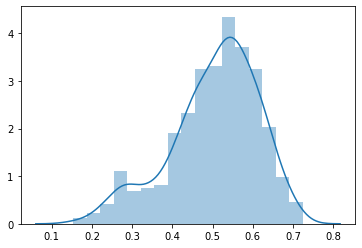

In [823]:
sns.distplot(y_predict)
plt.show()

In [771]:
# roc_auc_score(target_test,y_predict)

In [824]:
plan_create['prob'] = y_predict

In [825]:
plan_result = plan_create[plan_create['prob']>=threshold]

In [826]:
plan_result.shape

(129, 35)

In [827]:
plan_result['ad_account_id'].value_counts()

6621    40
6620    39
6868    35
6867    15
Name: ad_account_id, dtype: int64

In [787]:
plan_result[plan_result['ad_account_id']==6621]['image_id'].value_counts()

26445    7
28976    6
28744    5
27672    4
28678    4
29437    3
25562    3
28722    2
29512    1
Name: image_id, dtype: int64

In [828]:
plan_result['rank_ad_im'] = plan_result.groupby(['ad_account_id','image_id'])['prob'].rank(ascending=False)
# plan_result['rank_ad'] = plan_result.groupby(['ad_account_id'])['prob'].rank(ascending=False)
# plan_result['rank_im'] = plan_result.groupby(['image_id'])['prob'].rank(ascending=False)

In [829]:
plan_result = plan_result[plan_result['rank_ad_im']<=2]

In [830]:
plan_result.shape

(61, 36)

In [831]:
plan_result['ad_account_id'].value_counts()

6621    21
6620    18
6868    15
6867     7
Name: ad_account_id, dtype: int64

In [816]:
plan_result['gender'].value_counts()

GENDER_MALE    28
NONE           22
Name: gender, dtype: int64

In [820]:
plan_info_current[plan_info_current['source_id']==455940]

,ad_account_id,game_id,channel_id,source_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene
29650,6417,1001379,7162,455940,2021-01-30 01:06:18,SMART_BID_CONSERVATIVE,0,3000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000001111111111111111111111...,2566.0,1,NONE,[],[ANDROID],"[0, 11000]",[],[],"[4G, WIFI]",9.0,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN


In [819]:
df_create[df_create['gender']=='NONE']

,ad_account_id,game_id,channel_id,source_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,image_id,label_ids,amount,create_role_num,new_role_money,pay_role_user_num,roi,pay_cost,pay_cost_ok,amount_ok,pay_rate
3,6417,1001379,7162,455940,2021-01-30 01:06:18,SMART_BID_CONSERVATIVE,0,3000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000001111111111111111111111...,2566.00,1,NONE,[],1,"[0, 11000]",[],[],"[4G, WIFI]",9.0,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,28803,127,20783.89,1266.0,750.0,10.0,0.036086,2078.389000,1,1,0.007899
18,6819,1001379,7162,455757,2021-01-29 22:02:12,SMART_BID_CUSTOM,0,5200.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000000000111111111111111111...,2678.00,1,NONE,[],1,"[0, 11000]","[301305404, 301305405, 303061533, 306320294, 3...",[],"[4G, WIFI]",9.0,CURRENT,[],RETARGETING_EXCLUDE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,29403,20,7717.75,417.0,90.0,2.0,0.011661,3858.875000,1,1,0.004796
19,6819,1001379,7162,455758,2021-01-29 22:03:09,SMART_BID_CUSTOM,0,9000.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000000000111111111111111111...,2678.00,1,NONE,[],1,"[0, 11000]","[301305404, 301305405, 303061533, 306320294, 3...",[],"[4G, WIFI]",9.0,CURRENT,[],RETARGETING_EXCLUDE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,29403,20,19749.01,960.0,1940.0,6.0,0.098233,3291.501667,1,1,0.006250
22,6819,1001379,7162,456237,2021-01-30 20:03:09,SMART_BID_CUSTOM,0,3000.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000000000111111111111111111...,2678.00,1,NONE,[],1,"[0, 11000]","[301305404, 301305405, 303061533, 306320294, 3...",[],"[4G, WIFI]",9.0,CURRENT,[],RETARGETING_EXCLUDE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,25919,103,5558.73,169.0,128.0,3.0,0.023027,1852.910000,1,1,0.017751
23,6819,1001379,7162,456238,2021-01-30 20:03:09,SMART_BID_CUSTOM,0,3000.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000000000111111111111111111...,2678.00,1,NONE,[],1,"[0, 11000]","[301305404, 301305405, 303061533, 306320294, 3...",[],"[4G, WIFI]",9.0,CURRENT,[],RETARGETING_EXCLUDE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,25547,20,5495.29,508.0,72.0,3.0,0.013102,1831.763333,1,1,0.005906
38,6129,1001379,6867,456172,2021-01-30 16:02:06,SMART_BID_CUSTOM,0,3000.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",AD,FLOW_CONTROL_MODE_FAST,0000000000000000000000000001111111111111111111...,2888.00,0,NONE,[],1,"[0, 11000]","[301266831, 305139706, 306430191, 307112436, 3...",[],"[4G, WIFI]",8.0,CURRENT,[],RETARGETING_EXCLUDE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,25547,20,9599.87,655.0,2486.0,5.0,0.258962,1919.974000,1,1,0.007634
39,6129,1001379,6867,456181,2021-01-30 16:02:05,SMART_BID_CUSTOM,0,3000.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",CUSTOMER,FLOW_CONTROL_MODE_FAST,0000000000000000000000000001111111111111111111...,2888.00,0,NONE,[],1,"[0, 11000]",[],[],[],8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40]",NaN,NaN,NaN,26441,"-1,20",8491.89,993.0,1730.0,4.0,0.203724,2122.972500,1,1,0.004028
41,6129,1001379,6867,456177,2021-01-30 16:02:03,SMART_BID_CUSTOM,0,3000.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",CUSTOMER,FLOW_CONTROL_MODE_FAST,0000000000

In [817]:
df_create['gender'].value_counts()

GENDER_MALE    125
NONE            51
Name: gender, dtype: int64

In [818]:
df_create.head(100)

,ad_account_id,game_id,channel_id,source_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,image_id,label_ids,amount,create_role_num,new_role_money,pay_role_user_num,roi,pay_cost,pay_cost_ok,amount_ok,pay_rate
2,6417,1001379,7162,455943,2021-01-30 01:06:18,SMART_BID_CONSERVATIVE,0,3000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",ADVERTISER,FLOW_CONTROL_MODE_FAST,0000000000000000000000001111111111111111111111...,2566.00,0,GENDER_MALE,[],1,"[0, 11000]",[],[],"[4G, WIFI]",8.0,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",NaN,NaN,NaN,28803,127,23006.79,723.0,17234.0,13.0,0.749083,1769.753077,1,1,0.017981
3,6417,1001379,7162,455940,2021-01-30 01:06:18,SMART_BID_CONSERVATIVE,0,3000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000001111111111111111111111...,2566.00,1,NONE,[],1,"[0, 11000]",[],[],"[4G, WIFI]",9.0,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,28803,127,20783.89,1266.0,750.0,10.0,0.036086,2078.389000,1,1,0.007899
5,6417,1001379,7162,455939,2021-01-30 01:06:18,SMART_BID_CONSERVATIVE,0,3000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",CUSTOMER,FLOW_CONTROL_MODE_FAST,0000000000000000000000001111111111111111111111...,2566.00,0,GENDER_MALE,[],1,"[0, 11000]",[],[],[],7.1,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",NaN,NaN,NaN,28803,127,23249.23,1612.0,1828.0,9.0,0.078626,2583.247778,1,1,0.005583
13,6804,1001379,7162,455469,2021-01-29 21:20:47,SMART_BID_CUSTOM,0,3000.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000000000001111111111111111...,2566.00,1,GENDER_MALE,[],1,"[2000, 11000]",[],[],"[4G, WIFI]",8.0,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",NaN,NaN,NaN,28803,127,19685.67,604.0,1238.0,7.0,0.062888,2812.238571,1,1,0.011589
16,6804,1001379,7162,455466,2021-01-29 21:20:47,SMART_BID_CUSTOM,0,3000.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",ADVERTISER,FLOW_CONTROL_MODE_FAST,0000000000000000000000000000111111111111111111...,2566.00,0,GENDER_MALE,[],1,"[0, 11000]",[],[],"[4G, WIFI]",8.0,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",NaN,NaN,NaN,28803,127,5706.39,230.0,132.0,3.0,0.023132,1902.130000,1,1,0.013043
18,6819,1001379,7162,455757,2021-01-29 22:02:12,SMART_BID_CUSTOM,0,5200.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000000000111111111111111111...,2678.00,1,NONE,[],1,"[0, 11000]","[301305404, 301305405, 303061533, 306320294, 3...",[],"[4G, WIFI]",9.0,CURRENT,[],RETARGETING_EXCLUDE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,29403,20,7717.75,417.0,90.0,2.0,0.011661,3858.875000,1,1,0.004796
19,6819,1001379,7162,455758,2021-01-29 22:03:09,SMART_BID_CUSTOM,0,9000.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000000000111111111111111111...,2678.00,1,NONE,[],1,"[0, 11000]","[301305404, 301305405, 303061533, 306320294, 3...",[],"[4G, WIFI]",9.0,CURRENT,[],RETARGETING_EXCLUDE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,29403,20,19749.01,960.0,1940.0,6.0,0.098233,3291.501667,1,1,0.006250
22,6819,1001379,7162,456237,2021-01-30 20:03:09,SMART_BID_CUSTOM,0,3000.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,0000000000000000000000000000111111111111111111...,2678.00,1,NONE,[],1,"[0, 11000]","[301305404, 301305405, 303061533, 306320294, 3..."

In [758]:
ad_num = plan_result['ad_account_id'].value_counts().reset_index()

In [735]:
ad_num.columns

Index(['index', 'ad_account_id'], dtype='object')

In [736]:
ad_num.columns=['ad_account_id','plan_num']

In [ ]:
ad_num

In [759]:
ad_num

,index,ad_account_id
0,6621,8
1,6868,6
2,6620,3
3,6867,3


In [741]:
plan_result= pd.merge(plan_result,ad_num,on='ad_account_id',how='left')

In [742]:
plan_result.shape

(77, 36)

In [ ]:
plan_result

In [743]:
plan_result = plan_result.sample(n=20, replace=True, weights=plan_result['plan_num']).reset_index(drop=True)

In [744]:
plan_result.shape

(20, 36)

In [747]:
plan_result['image_id'].value_counts()

28976    7
26445    7
27672    2
28744    2
25562    1
28678    1
Name: image_id, dtype: int64

In [777]:
plan_result.shape

(103, 38)

In [778]:
plan_result['ad_account_id'].value_counts()

6621    35
6868    29
6620    27
6867    12
Name: ad_account_id, dtype: int64

In [779]:
plan_result = plan_result[plan_result['rank_ad']<=10]

In [780]:
plan_result = plan_result[plan_result['rank_im']<=8]

In [781]:
plan_result = plan_result[plan_result['rank_ad_im']<=2]

In [782]:
plan_result['ad_account_id'].value_counts()

6620    8
6621    7
6868    6
Name: ad_account_id, dtype: int64

In [709]:
ad_account_id_group = np.array([6620, 6621, 6867, 6868])

In [714]:
ad_num.index

Int64Index([6620, 6621, 6868], dtype='int64')

In [722]:
ad_retain = []
for ad in ad_account_id_group:
    if ad not in ad_num.index:
        ad_retain.append(ad)
    if ad in ad_num.index:
        if ad_num[ad]<2:
            ad_retain.append(ad)
    
        

In [710]:
ad_num = plan_result['ad_account_id'].value_counts()

In [711]:
ad_num

6620    8
6621    7
6868    6
Name: ad_account_id, dtype: int64

In [706]:
plan_result['image_id'].value_counts()

26445    6
27672    4
25562    3
28678    3
28976    2
28744    2
28722    1
Name: image_id, dtype: int64

In [707]:
plan_result['image_id'].value_counts().sum()

21

In [753]:
plan_result.shape

(20, 36)

In [754]:
plan_result.drop(['create_time','create_date','prob','plan_num','label_ids'],axis=1,inplace=True)

In [ ]:
['ad_account_id', 'image_id', 'game_id', 'platform', 'android_osv',
       'ios_osv', 'budget', 'retargeting_type', 'retargeting_tags_include',
       'retargeting_tags_exclude', 'interest_action_mode', 'action_scene',
       'action_days', 'action_categories', 'interest_categories',
       'smart_bid_type', 'adjust_cpa', 'cpa_bid', 'bid2', 'delivery_range',
       'inventory_type', 'city', 'location_type', 'gender', 'age', 'ac',
       'launch_price', 'auto_extend_enabled', 'hide_if_exists',
       'hide_if_converted', 'schedule_time', 'flow_control_mode']

In [801]:
len(set(['ad_account_id', 'image_id', 'game_id', 'platform', 'android_osv',
       'ios_osv', 'budget', 'retargeting_type', 'retargeting_tags_include',
       'retargeting_tags_exclude', 'interest_action_mode', 'action_scene',
       'action_days', 'action_categories', 'interest_categories',
       'smart_bid_type', 'adjust_cpa', 'cpa_bid', 'delivery_range', 'city',
       'location_type', 'gender', 'age', 'ac', 'launch_price',
       'auto_extend_enabled', 'hide_if_exists', 'hide_if_converted',
       'schedule_time', 'flow_control_mode']))

30

In [802]:
np.setdiff1d(plan_result.columns,['ad_account_id', 'image_id', 'game_id', 'platform', 'android_osv',
       'ios_osv', 'budget', 'retargeting_type', 'retargeting_tags_include',
       'retargeting_tags_exclude', 'interest_action_mode', 'action_scene',
       'action_days', 'action_categories', 'interest_categories',
       'smart_bid_type', 'adjust_cpa', 'cpa_bid', 'delivery_range', 'city',
       'location_type', 'gender', 'age', 'ac', 'launch_price',
       'auto_extend_enabled', 'hide_if_exists', 'hide_if_converted',
       'schedule_time', 'flow_control_mode'])

array(['create_date', 'create_time', 'inventory_type', 'label_ids',
       'prob', 'rank_ad_im'], dtype=object)

In [798]:
len(set(plan_result.columns))

36

In [756]:
plan_result.columns

Index(['ad_account_id', 'image_id', 'game_id', 'platform', 'android_osv',
       'ios_osv', 'budget', 'retargeting_type', 'retargeting_tags_include',
       'retargeting_tags_exclude', 'interest_action_mode', 'action_scene',
       'action_days', 'action_categories', 'interest_categories',
       'smart_bid_type', 'adjust_cpa', 'cpa_bid', 'delivery_range', 'city',
       'location_type', 'gender', 'age', 'ac', 'launch_price',
       'auto_extend_enabled', 'hide_if_exists', 'hide_if_converted',
       'schedule_time', 'flow_control_mode', 'inventory_type'],
      dtype='object')

In [757]:
plan_result.shape

(20, 31)

In [797]:
len(set(['ad_account_id', 'image_id', 'game_id', 'platform', 'android_osv',
       'ios_osv', 'budget', 'retargeting_type', 'retargeting_tags_include',
       'retargeting_tags_exclude', 'interest_action_mode', 'action_scene',
       'action_days', 'action_categories', 'interest_categories',
       'smart_bid_type', 'adjust_cpa', 'cpa_bid', 'delivery_range', 'city',
       'location_type', 'gender', 'age', 'ac', 'launch_price',
       'auto_extend_enabled', 'hide_if_exists', 'hide_if_converted',
       'schedule_time', 'flow_control_mode']))

30

In [ ]:
,

In [799]:
plan_result.head()

,ad_account_id,image_id,game_id,platform,android_osv,ios_osv,budget,retargeting_type,retargeting_tags_include,retargeting_tags_exclude,interest_action_mode,action_scene,action_days,action_categories,interest_categories,smart_bid_type,adjust_cpa,cpa_bid,delivery_range,city,location_type,gender,age,ac,launch_price,auto_extend_enabled,hide_if_exists,hide_if_converted,schedule_time,flow_control_mode,inventory_type,create_time,create_date,label_ids,prob,rank_ad_im
8,6620,25562,1001379,[ANDROID],NONE,NONE,3300,RETARGETING_EXCLUDE,[],"[307112933, 307112436, 306346478, 305139706, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2805.76,DEFAULT,[],CURRENT,NONE,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",[],"[0, 11000]",0,0,APP,0000000000000000000000000000111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",2021-02-05 18:00:09.909400,2021-02-05,20,0.693707,1.0
23,6620,26445,1001379,[ANDROID],NONE,NONE,3300,RETARGETING_EXCLUDE,[],"[307112933, 307112436, 306346478, 305139706, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2868.00,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[4G, WIFI]","[0, 11000]",0,0,CUSTOMER,0000000000000000000000000011111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",2021-02-05 18:00:09.909400,2021-02-05,"-1,20",0.725064,1.0
31,6620,27672,1001379,[ANDROID],9.0,NONE,3300,RETARGETING_EXCLUDE,[],"[307112933, 307112436, 306346478, 305139706, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2868.00,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,AD,0000000000000000000000000000111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_VIDEO_FEED]",2021-02-05 18:00:09.909400,2021-02-05,20,0.694307,1.0
33,6620,28678,1001379,[ANDROID],8.0,NONE,3300,RETARGETING_EXCLUDE,[],"[307112933, 307112706, 307112436, 306430191, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2996.69,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_ABOVE_50, AGE_BETWEEN_18_23, AGE_BETWEEN_...",[],"[0, 11000]",0,0,CUSTOMER,0000000000000000000000000011111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_UNION_SLOT,...",2021-02-05 18:00:09.909400,2021-02-05,127,0.657929,1.0
46,6620,28722,1001379,[ANDROID],8.0,NONE,3300,RETARGETING_EXCLUDE,[],"[307112933, 307112436, 306346478, 305139706, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2833.47,DEFAULT,[],CURRENT,NONE,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",[],"[0, 11000]",0,0,APP,0000000000000000000000111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_UNION_SLOT,...",2021-02-05 18:00:09.909400,2021-02-05,127,0.681503,1.0


In [684]:
plan_result = plan_result.sort_values(by='prob',ascending=False).reset_index(drop=True).iloc[0:20]

In [683]:
plan_result['image_id'].value_counts()

26445    8
28678    8
27672    7
28976    6
28744    6
25562    5
28722    4
29437    3
29000    1
29477    1
29512    1
Name: image_id, dtype: int64

In [ ]:
plan_result['']

In [685]:
plan_result

,ad_account_id,image_id,game_id,platform,android_osv,ios_osv,budget,retargeting_type,retargeting_tags_include,retargeting_tags_exclude,interest_action_mode,action_scene,action_days,action_categories,interest_categories,smart_bid_type,adjust_cpa,cpa_bid,delivery_range,city,location_type,gender,age,ac,launch_price,auto_extend_enabled,hide_if_exists,hide_if_converted,schedule_time,flow_control_mode,inventory_type,create_time,create_date,label_ids,prob,rank
0,6620,26445,1001379,[ANDROID],NONE,NONE,3300,RETARGETING_EXCLUDE,[],"[307112933, 307112436, 306346478, 305139706, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2868.00,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[4G, WIFI]","[0, 11000]",0,0,CUSTOMER,0000000000000000000000000011111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",2021-02-05 18:00:09.909400,2021-02-05,"-1,20",0.725064,1.0
1,6620,26445,1001379,[ANDROID],8.0,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2964.98,DEFAULT,[],CURRENT,NONE,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,CUSTOMER,0000000000000000000000000000111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_UNION_SLOT,...",2021-02-05 18:00:09.909400,2021-02-05,"-1,20",0.711517,2.0
2,6621,26445,1001379,[ANDROID],8.0,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2888.00,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...","[4G, WIFI]","[0, 11000]",0,0,CUSTOMER,0000000000000000000000000011111111111111111111...,FLOW_CONTROL_MODE_BALANCE,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",2021-02-05 18:00:09.909400,2021-02-05,"-1,20",0.698620,1.0
3,6620,27672,1001379,[ANDROID],9.0,NONE,3300,RETARGETING_EXCLUDE,[],"[307112933, 307112436, 306346478, 305139706, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2868.00,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,AD,0000000000000000000000000000111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_VIDEO_FEED]",2021-02-05 18:00:09.909400,2021-02-05,20,0.694307,1.0
4,6621,26445,1001379,[ANDROID],8.1,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2888.00,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_ABOVE_50, AGE_BETWEEN_18_23, AGE_BETWEEN_...","[4G, WIFI]","[1500, 11000]",0,0,APP,0000000000000000000000000011111111111111111111...,FLOW_CONTROL_MODE_FAST,"[UNION_BOUTIQUE_GAME, INVENTORY_AWEME_FEED]",2021-02-05 18:00:09.909400,2021-02-05,"-1,20",0.693811,2.0
5,6620,25562,1001379,[ANDROID],NONE,NONE,3300,RETARGETING_EXCLUDE,[],"[307112933, 307112436, 306346478, 305139706, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2805.76,DEFAULT,[],CURRENT,NONE,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",[],"[0, 11000]",0,0,APP,0000000000000000000000000000111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",2021-02-05 18:00:09.909400,2021-02-05,20,0.693707,1.0
6,6868,26445,1001379,[ANDROID],8.0,NONE,3300,RETARGETING_INCLUDE,"[316358204, 316250745, 316240150, 316239431, 3...",[],UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2997.16,DEFAULT,[],CURRENT,NONE,[],[],"[0, 11000]",0,0,AD,0000000000000000000000000000111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",2021-02-05 18:00:09.909400,2021-02-05,"-1,20",0.691928,1.0
7,6868,26445,1001379,[ANDROID],8.0,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2888.00,DEFAULT,[],CURRENT,NONE,[],"[4G, WIFI]","[0, 11000]",1,0,APP,0000000000000000000000111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_UNION_SLOT,...",2021-02-05 18:00:09.909400,2021-02-05,"-1,20",0.690059,2.0
8,6620,27672,1001379,[ANDROID],8.0,NONE,3300,RETARGETING_EXCLUDE,[],"[301266831, 305139706, 306430191, 307112436, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2888.00,DEFAULT,[],CUR

### 构造新计划

In [861]:
# 获取score_image (分数大于550的image_id)
def get_score_image():
    conn = connect(host='192.168.0.88', port=10000, auth_mechanism='PLAIN', user='hadoop',
                    password='Ycjh8FxiaoMtShZRd3-97%3hCEL0CK4ns1w', database='default')
    cursor = conn.cursor()
    sql_engine = 'set hive.execution.engine=tez'
    sql = 'select image_id from dws.dws_image_score_d where media_id=10 and score>=580 and dt=CURRENT_DATE group by image_id'
    cursor.execute(sql_engine)
    cursor.execute(sql)
    result = as_pandas(cursor)
    result['image_id'].values
    # 关闭链接
    cursor.close()
    conn.close()
    
    return result['image_id'].values

In [862]:
plan_info['create_time'] = pd.to_datetime(plan_info['create_time'])
plan_info_current = plan_info[plan_info['create_time']>=pd.datetime.now() - pd.DateOffset(8)]

In [863]:
# 获取近期计划的运营数据
def get_now_plan_roi():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                        passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.channel_id as 'channel_id',
            a.source_id as 'source_id',
            a.amount as 'amount',
            a.create_role_num as 'create_role_num',
            b.new_role_money as 'new_role_money',
            b.pay_role_user_num as 'pay_role_user_num'
        FROM
            (
            SELECT
                a.channel_id,
                a.source_id,
                sum(a.amount) as 'amount',
                sum(a.create_role_num) as 'create_role_num' 
            FROM
                db_stdata.st_lauch_report a
            WHERE
                a.tdate_type = 'day' 
                AND a.tdate >= date(NOW() - interval 192 hour)
                AND a.tdate<=date(NOW() - interval 24 hour)
                AND a.amount > 0 
                AND a.media_id = 10 
                AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL )
                GROUP BY a.channel_id,a.source_id
                ) a
            LEFT JOIN (
            SELECT
                c.channel_id,
                c.source_id,
                sum( c.create_role_money ) new_role_money,
                IFNULL( sum( c.pay_role_user_num ), 0 ) AS pay_role_user_num 
            FROM
                db_stdata.st_game_days c
            WHERE
                c.report_days = 8 
                AND c.tdate = date(NOW() - interval 24 hour)
                AND c.tdate_type = 'day' 
                AND c.query_type = 13 
                AND c.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
            GROUP BY
                c.channel_id,
                c.source_id 
            HAVING
                ( new_role_money > 0 OR pay_role_user_num > 0 ) 
            ) b ON a.source_id = b.source_id 
            AND a.channel_id = b.channel_id 
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [864]:
now_plan_roi = get_now_plan_roi()
score_image = get_score_image()

In [865]:
df_create = pd.merge(plan_info_current,image_info,on=['channel_id','source_id'],how='left')
df_create = pd.merge(df_create,now_plan_roi,on=['channel_id','source_id'],how='inner')
df_create = df_create[df_create['pay_role_user_num'].notna()]
df_create['roi'] = df_create['new_role_money']/df_create['amount']
df_create['pay_cost'] = df_create['amount']/df_create['pay_role_user_num']

In [866]:
df_create['platform'] = df_create['platform'].astype(str)
df_create['platform'] = df_create['platform'].map({"['ANDROID']":1,"['IOS']":2})
df_create['platform'] = df_create['platform'].astype(int)
df_create['pay_cost_ok'] = df_create.apply(lambda x:1 if (x.platform==1)&(x.pay_cost<=5000) else (1 if 
                            (x.platform==2)&(x.pay_cost<=8000) else 0), axis=1)
df_create['amount_ok'] = df_create.apply(lambda x:1 if (x.platform==1)&(x.amount>=5000) else (1 if 
                            (x.platform==2)&(x.amount>=8000) else 0), axis=1)
df_create = df_create[(df_create['amount_ok']==1)&(df_create['pay_cost_ok']==1)]
df_create = df_create[df_create['roi']>0.01]

In [867]:
df_create.dropna(subset=['image_id'],inplace=True)
df_create['image_id'] = df_create['image_id'].astype(int)
df_create['pay_rate'] = df_create['pay_role_user_num'] / df_create['create_role_num']

In [868]:
df_create = df_create[df_create['platform']==1]

In [869]:
df_create.shape

(184, 44)

In [870]:
def create_plan(df,score_image):
    # 选ad_account_id、image_id、game_id，每个账号+素材8条
    ad_account_id_group = np.array([6620,6621,6867,6868])
    image_id_group =np.intersect1d(df['image_id'].unique(),score_image)
    plan = pd.DataFrame()
    for ad_account in ad_account_id_group:
        for image in image_id_group:
    #         print(image)
            temp = pd.DataFrame({'ad_account_id':[ad_account],'image_id':[image]})
            plan = plan.append(temp)
    #         print(temp)
    plan = pd.DataFrame(np.repeat(plan.values,8,axis=0), columns=plan.columns)
    plan['game_id'] = 1001379

    # 选platform测试期默认[ANDROID]
    plan['platform']='[ANDROID]'

    # 选android_osv
    count_df = pd.DataFrame(data=df['android_osv'].value_counts()).reset_index()
    count_df.columns = ['col','counts']
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['android_osv']=plan['platform'].apply(lambda x:'NONE' if x=='[IOS]' else 
                                               np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0])

    # 选ios_osv
    count_df = pd.DataFrame(data=df['ios_osv'].value_counts()).reset_index()
    count_df.columns = ['col','counts']
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['ios_osv']=plan['platform'].apply(lambda x:'NONE' if x=='[ANDROID]' else 
                                               np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0])

    # 选budget 
    plan['budget']= plan['platform'].apply(lambda x:3300 if x=='[ANDROID]' else 4000)

    # 选'retargeting_type','retargeting_tags_include','retargeting_tags_exclude'  人群包定向
    sample_df = df[['retargeting_type','retargeting_tags_include','retargeting_tags_exclude','pay_rate']]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True, weights=sample_df['pay_rate']).drop('pay_rate',axis=1).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选'interest_action_mode','action_scene','action_days','action_categories' ,'interest_categories' 行为兴趣
    sample_df = df[['interest_action_mode','action_scene','action_days','action_categories','interest_categories','pay_rate']]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True, weights=sample_df['pay_rate']).drop('pay_rate',axis=1).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选'smart_bid_type','adjust_cpa','cpa_bid'出价方式
    sample_df = df[['smart_bid_type','adjust_cpa','cpa_bid','pay_rate']]
    sample_df = sample_df[sample_df['cpa_bid']>=1500]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True, weights=sample_df['pay_rate']).drop('pay_rate',axis=1).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选
    cols = ['delivery_range','city','location_type','gender','age','ac','launch_price',
           'auto_extend_enabled','hide_if_exists','hide_if_converted','schedule_time','flow_control_mode']
    for col in cols:
        count_df = pd.DataFrame(data=df[col].value_counts()).reset_index()
        count_df.columns = ['col','counts']
        count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
        plan[col]=plan.apply(lambda x:np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0], axis=1)

    # 选inventory_type 创意投放位置
    count_df = pd.DataFrame(data=df['inventory_type'].value_counts()).reset_index()
    count_df.columns = ['col','counts']

    for i in range(count_df.shape[0]):
        values = count_df.loc[i,'col']

        for value in values:
            if value== None:
                values.remove(value)
        a = np.empty(1, dtype=object)
        a[0] = values
        count_df.loc[i,'col'] = a
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['inventory_type']=plan.apply(lambda x:np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0], axis=1)
    plan['create_time'] = pd.to_datetime(pd.datetime.now())
    plan['create_date'] = pd.to_datetime(pd.datetime.now().date())
    
    return plan

In [871]:
plan_create = create_plan(df_create, score_image)

In [872]:
image_info.dropna(subset=['image_id'],inplace=True)
image_info['image_id'] = image_info['image_id'].astype(int)
plan_create = pd.merge(plan_create,image_info[['image_id','label_ids']].drop_duplicates(),on='image_id',how='left')

In [873]:
plan_create.head()

,ad_account_id,image_id,game_id,platform,android_osv,ios_osv,budget,retargeting_type,retargeting_tags_include,retargeting_tags_exclude,interest_action_mode,action_scene,action_days,action_categories,interest_categories,smart_bid_type,adjust_cpa,cpa_bid,delivery_range,city,location_type,gender,age,ac,launch_price,auto_extend_enabled,hide_if_exists,hide_if_converted,schedule_time,flow_control_mode,inventory_type,create_time,create_date,label_ids
0,6620,24402,1001379,[ANDROID],8.0,NONE,3300,RETARGETING_INCLUDE,"[316358204, 316250745, 316240150, 316239431, 3...","[316737743, 316365390, 315861116, 315860988, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2947.27,DEFAULT,"[140800, 512000, 430600, 140100, 11, 370700, 6...",ALL,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,CUSTOMER,0000000000000000000000111111111111111111111111...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],2021-02-07 11:23:37.250400,2021-02-07,22
1,6620,24402,1001379,[ANDROID],9.0,NONE,3300,RETARGETING_EXCLUDE,[],"[307112933, 307112436, 306346478, 305139706, 3...",UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2799.28,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,CUSTOMER,0000000000000000000000000000111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_FEED, INVENTORY_HOTSOON_FEED, INVEN...",2021-02-07 11:23:37.250400,2021-02-07,22
2,6620,24402,1001379,[ANDROID],8.0,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2906.46,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,CUSTOMER,0000000000000000000000111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_FEED, INVENTORY_HOTSOON_FEED, INVEN...",2021-02-07 11:23:37.250400,2021-02-07,22
3,6620,24402,1001379,[ANDROID],8.0,NONE,3300,RETARGETING_EXCLUDE,[],[316309615],UNLIMITED,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2920.66,DEFAULT,[],CURRENT,NONE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[4G, WIFI]","[0, 11000]",0,0,CUSTOMER,0000000000000000000000000000111111111111111111...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],2021-02-07 11:23:37.250400,2021-02-07,22
4,6620,24402,1001379,[ANDROID],8.0,NONE,3300,RETARGETING_EXCLUDE,[],[316627170],RECOMMEND,NaN,NaN,NaN,[],SMART_BID_CUSTOM,0.0,2974.35,DEFAULT,[],CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40]","[4G, WIFI]","[0, 11000]",0,0,APP,0000000000000000000000000000111111111111111111...,FLOW_CONTROL_MODE_BALANCE,"[INVENTORY_HOTSOON_FEED, INVENTORY_UNION_SLOT,...",2021-02-07 11:23:37.250400,2021-02-07,22


In [874]:
plan_create.shape

(544, 34)

In [875]:
df_create['gender'].value_counts()

GENDER_MALE    125
NONE            59
Name: gender, dtype: int64